In [58]:
using Flux3D, Makie,Flux
using GeometryBasics
using AbstractPlotting


In [25]:
Makie.AbstractPlotting.set_theme!(show_axis = false, scale=false)

In [26]:
m = load_trimesh("teapot.obj")

TriMesh{Float32, UInt32, Array} Structure:
    Batch size: 1
    Max verts: 3644
    Max faces: 6320
    offset: -1
    Storage type: Array

In [27]:
p = PointCloud(m)

PointCloud{Float32} Structure:
    Batch size: 1
    Points: 1000
    Normals 0
    Storage type: Array{Float32,3}

In [72]:
v = VoxelGrid(m)

VoxelGrid{Float32} Structure:
    Batch size: 1
    Voxels features: 32
    Storage type: Array{Float32,4}

In [54]:
vbox(Flux3D.visualize(m), Flux3D.visualize(p), Flux3D.visualize(v))

LoadError: UndefVarError: visualize not defined

In [67]:
v

VoxelGrid{Float32} Structure:
    Batch size: 1
    Voxels features: 32
    Storage type: Array{Float32,4}

┌ Warning: Showing scene as text. This happens because `AbstractPlotting.inline!(true)` is set.
│ This needs to be false to show a plot in a window when in the REPL.
└ @ AbstractPlotting /Users/amiraabdel-rahman/.julia/packages/AbstractPlotting/ru2ib/src/display.jl:135


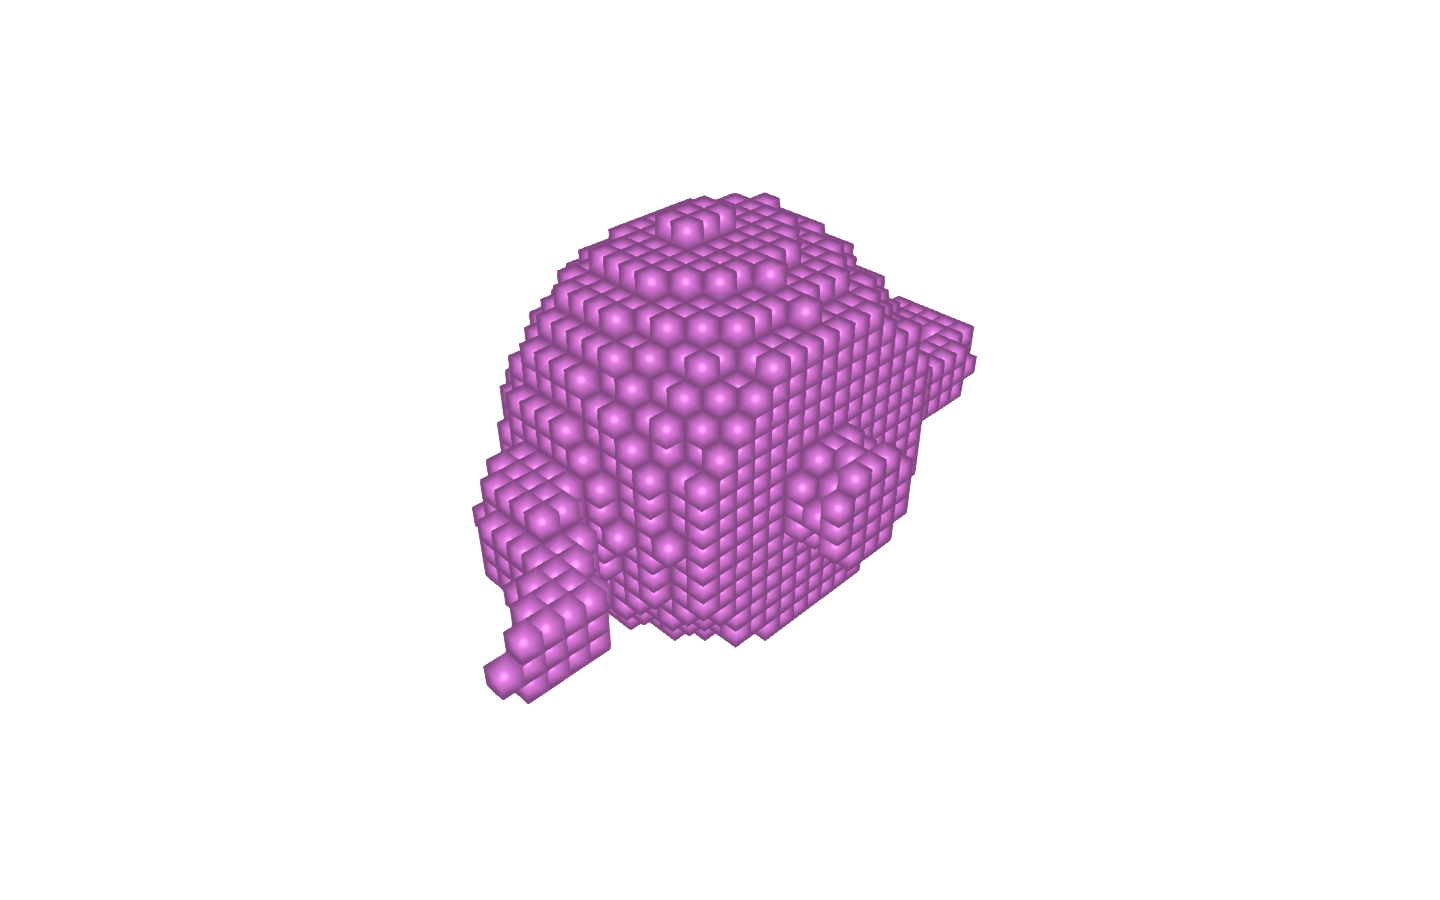

In [66]:
visualize(v)

In [ ]:
using GLMakie
using AbstractPlotting
AbstractPlotting.inline!(true)


┌ Warning: Showing scene as text. This happens because `AbstractPlotting.inline!(true)` is set.
│ This needs to be false to show a plot in a window when in the REPL.
└ @ AbstractPlotting /Users/amiraabdel-rahman/.julia/packages/AbstractPlotting/ru2ib/src/display.jl:135


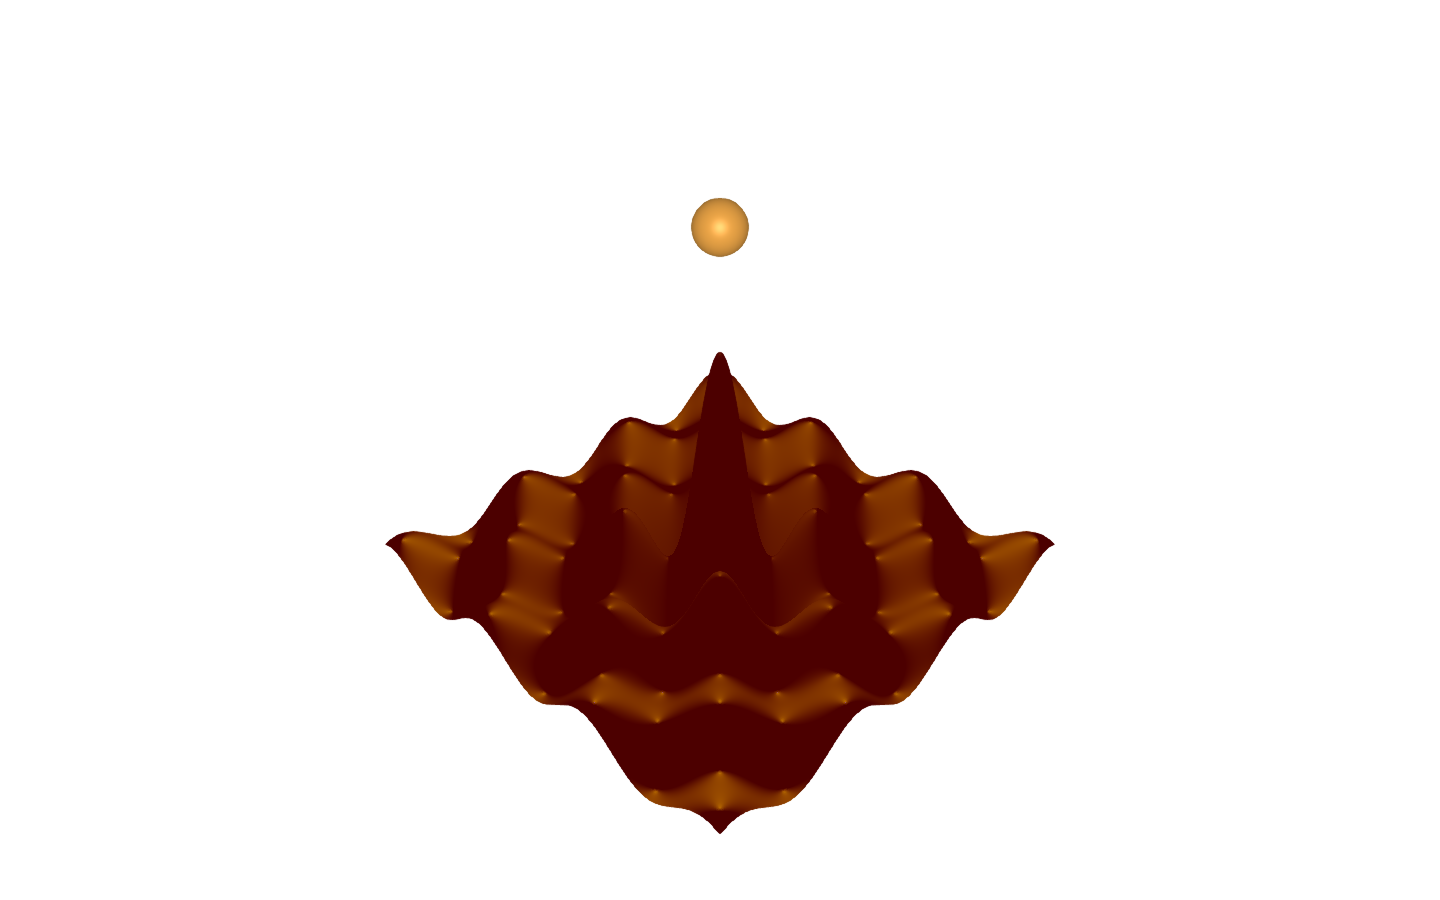

In [41]:

xs = -10:0.1:10
ys = -10:0.1:10
zs = [10 * (cos(x) * cos(y)) * (.1 + exp(-(x^2 + y^2 + 1)/10)) for x in xs, y in ys]


# Or use an LScene within a Figure
scene = Scene()
surface!(
    scene, xs, ys, zs, colormap = (:white, :white),

    # Light comes from (0, 0, 15), i.e the sphere
    lightposition = Vec3f0(0, 0, 15),
    # base light of the plot only illuminates red colors
    ambient = Vec3f0(0.3, 0, 0),
    # light from source (sphere) illuminates yellow colors
    diffuse = Vec3f0(0.4, 0.4, 0),
    # reflections illuminate blue colors
    specular = Vec3f0(0, 0, 1.0),
    # Reflections are sharp
    shininess = 128f0
)
mesh!(scene, Sphere(Point3f0(0, 0, 15), 1f0), color=RGBf0(1, 0.7, 0.3))
scene

In [64]:
"""
    visualize(pcloud::PointCloud; kwargs...)
Visualize PointCloud `pcloud` at `index`.
Dimension of points in PointCloud `pcloud` must be 3.
### Optional Arguments:
- color (Symbol)       - Color of the marker, default `:blue`
- markersize (Number)  - Size of the marker, default `npoints(pcloud)/5000`
"""
function visualize(p::PointCloud, index::Number = 1; kwargs...)
    points = cpu(p[index])
    size(points, 1) == 3 || error("dimension of points in PointCloud must be 3.")

    kwargs = convert(Dict{Symbol,Any}, kwargs)
    get!(kwargs, :color, :lightgreen)
    get!(kwargs, :markersize, npoints(p) / 5000)

    AbstractPlotting.meshscatter(points[1, :], points[2, :], points[3, :]; kwargs...)
end

"""
    visualize(m::TriMesh, index::Int=1; kwargs...)
Visualize mesh at `index` in TriMesh `m`.
### Optional Arguments:
- color (Symbol)       - Color of the marker, default `:red`
"""
function visualize(m::GeometryBasics.Mesh; kwargs...) where {T,R}
    kwargs = convert(Dict{Symbol,Any}, kwargs)
    get!(kwargs, :color, :orange)

    AbstractPlotting.mesh(GeometryBasics.normal_mesh(m); kwargs...)
end

visualize(m::TriMesh, index::Int = 1; kwargs...) = visualize(GBMesh(m, index); kwargs...)

"""
    visualize(v::VoxelGrid, index::Int=1; kwargs...)
Visualize voxel at `index` in VoxelGrid `v`.
### Optional Arguments:
- color (Symbol)       - Color of the marker, default `:red`
"""
function visualize(
    v::VoxelGrid,
    index::Int = 1,
    thresh::Number = 0.49f0;
    algo = :Exact,
    kwargs...,
)
    algo in [:Exact, :MarchingCubes, :MarchingTetrahedra, :NaiveSurfaceNets] ||
        error("given algo: $(algo) is not supported. Accepted algo are
              {:Exact,:MarchingCubes, :MarchingTetrahedra, :NaiveSurfaceNets}.")
    kwargs = convert(Dict{Symbol,Any}, kwargs)
    get!(kwargs, :color, :violet)
    method = algo == :Exact ? Flux3D._voxel_exact : Flux3D._voxel_algo
    v, f = method(cpu(v[index]), Float32(thresh), algo)

    m = GBMesh(v, f)
    AbstractPlotting.mesh(GeometryBasics.normal_mesh(m); kwargs...)
end

visualize

In [69]:
v, f = Flux3D._voxel_exact(cpu(v[1]), Float32(0.49f0), :Exact)

(Float32[14.0 14.0 … 16.0 16.0; 17.0 17.0 … 20.0 20.0; 4.0 5.0 … 24.0 25.0], UInt32[0x00000001 0x00000001 … 0x00002d52 0x00002d52; 0x00000007 0x00000003 … 0x00002d56 0x00002d58; 0x00000005 0x00000007 … 0x00002d58 0x00002d54])

In [70]:
v

3×11608 Array{Float32,2}:
 14.0  14.0  14.0  14.0  15.0  15.0  …  15.0  15.0  16.0  16.0  16.0  16.0
 17.0  17.0  18.0  18.0  17.0  17.0     20.0  20.0  19.0  19.0  20.0  20.0
  4.0   5.0   4.0   5.0   4.0   5.0     24.0  25.0  24.0  25.0  24.0  25.0

In [71]:
f

3×17412 Array{UInt32,2}:
 0x00000001  0x00000001  0x00000001  …  0x00002d51  0x00002d52  0x00002d52
 0x00000007  0x00000003  0x00000004     0x00002d56  0x00002d56  0x00002d58
 0x00000005  0x00000007  0x00000003     0x00002d52  0x00002d58  0x00002d54

┌ Warning: Showing scene as text. This happens because `AbstractPlotting.inline!(true)` is set.
│ This needs to be false to show a plot in a window when in the REPL.
└ @ AbstractPlotting /Users/amiraabdel-rahman/.julia/packages/AbstractPlotting/ru2ib/src/display.jl:135


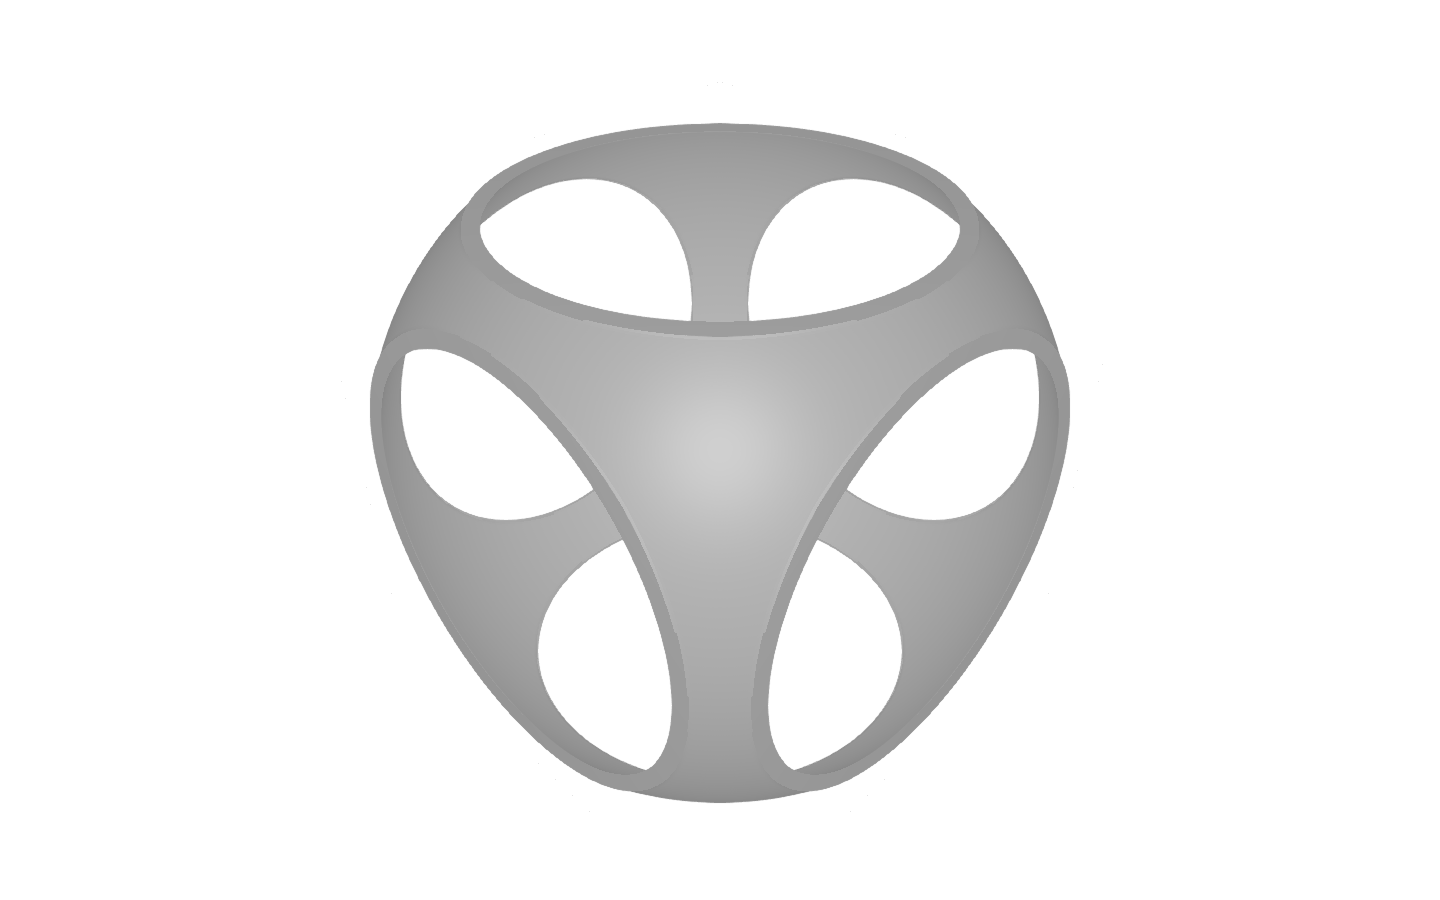

In [79]:
r = LinRange(-1, 1, 100)
cube = [(x.^2 + y.^2 + z.^2) for x = r, y = r, z = r]
cube_with_holes = cube .* (cube .> 1.4)

volume(cube_with_holes, colormap=:grays,algorithm = :iso, isorange = 0.05, isovalue = 1.7)

In [74]:
cube

100×100×100 Array{Float64,3}:
[:, :, 1] =
 3.0      2.96     2.92082  2.88246  …  2.88246  2.92082  2.96     3.0
 2.96     2.92001  2.88083  2.84247     2.84247  2.88083  2.92001  2.96
 2.92082  2.88083  2.84165  2.80329     2.80329  2.84165  2.88083  2.92082
 2.88246  2.84247  2.80329  2.76492     2.76492  2.80329  2.84247  2.88246
 2.84491  2.80492  2.76574  2.72737     2.72737  2.76574  2.80492  2.84491
 2.80818  2.76819  2.72901  2.69064  …  2.69064  2.72901  2.76819  2.80818
 2.77227  2.73227  2.69309  2.65473     2.65473  2.69309  2.73227  2.77227
 2.73717  2.69717  2.65799  2.61963     2.61963  2.65799  2.69717  2.73717
 2.70289  2.66289  2.62371  2.58535     2.58535  2.62371  2.66289  2.70289
 2.66942  2.62943  2.59025  2.55188     2.55188  2.59025  2.62943  2.66942
 2.63677  2.59678  2.5576   2.51923  …  2.51923  2.5576   2.59678  2.63677
 2.60494  2.56494  2.52576  2.4874      2.4874   2.52576  2.56494  2.60494
 2.57392  2.53393  2.49475  2.45638     2.45638  2.49475  2.53393